In [5]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from PIL import Image
import os

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data.dataloader import DataLoader, Dataset

(32, 32, 3)


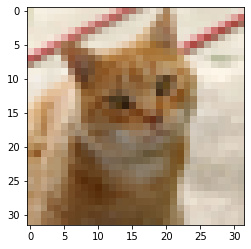

In [9]:
img_name = 'cat.jpg'
n_SR = 2
n_PE = 10
dimx, dimy = 32, 32
epochs = 5000
lr = 1e-5
save_name = img_name.split('.')[0] + '_' + str(dimx) + 'x' + str(dimy) + '_' + 'PE' + str(n_PE) + 'SR' + str(n_SR) + '_' + 'epoch' + str(epochs) + '.png'

img = Image.open(os.path.join('Data', img_name))
img = np.array(img.resize((dimx, dimy)))
print(img.shape)
plt.imshow(img)
plt.show()

In [10]:
class MyDataset(Dataset):
    def __init__(self, df):
        x=df.iloc[:,0:-3].values
        y=df.iloc[:,-3:].values
        self.x_train=torch.tensor(x, dtype=torch.float32)
        self.y_train=torch.tensor(y, dtype=torch.float32)

    def __len__(self):
        return len(self.y_train)

    def __getitem__(self,idx):
        return self.x_train[idx], self.y_train[idx]

class PE_model(nn.Module):
    def __init__(self, inp_size, out_size):
        super().__init__()
        self.hidden1 = nn.Linear(inp_size, 256)
        self.hidden2 = nn.Linear(256, 256)
        self.hidden3 = nn.Linear(256, 256)
        self.hidden4 = nn.Linear(256, 256)
        self.hidden5 = nn.Linear(256, 256)
        # self.act = nn.ReLU()
        self.act = nn.LeakyReLU()
        self.outact = nn.Sigmoid()
        self.output = nn.Linear(256, out_size)

    def forward(self, x):
        x = self.act(self.hidden1(x))
        x = self.act(self.hidden2(x))
        x = self.act(self.hidden3(x))
        x = self.act(self.hidden4(x))
        x = self.act(self.hidden5(x))
        x = self.outact(self.output(x))
        # x = self.output(x)
        return x
        
def SuperResolution(img, n_SR=2, n_PE=5, epochs=1000, lr=1e-5):
    rs, cs, rys, gys, bys = [], [], [], [], []

    for r in range(img.shape[0]):
        for c in range(img.shape[1]):
            rs.append(r)
            cs.append(c)
            rys.append(img[r,c,0]/255)
            gys.append(img[r,c,1]/255)
            bys.append(img[r,c,2]/255)
    df = pd.DataFrame({'rs':rs, 'cs':cs, 'ry':rys, 'gy':gys, 'by':bys})

    rSR, cSR = [], []
    for r in range(n_SR*img.shape[0]):
        for c in range(n_SR*img.shape[1]):
            rSR.append(r)
            cSR.append(c)
    df_SR = pd.DataFrame({'rSR':rSR, 'cSR':cSR})

    X = df.iloc[:, :-3].copy()
    Y = df.iloc[:, -3:].copy()
    for i in range(n_PE):
        X[f'sin_2^{i+1}_rs'] = (X['rs']*(2**i)*np.pi/180).map(np.sin)
        X[f'cos_2^{i+1}_rs'] = (X['rs']*(2**i)*np.pi/180).map(np.cos)
        X[f'sin_2^{i+1}_cs'] = (X['cs']*(2**i)*np.pi/180).map(np.sin)
        X[f'cos_2^{i+1}_cs'] = (X['cs']*(2**i)*np.pi/180).map(np.cos)
    df = pd.concat([X, Y], axis=1)

    XSR = df_SR.copy()
    XSR = XSR/n_SR
    for i in range(n_PE):
        XSR[f'sin_2^{i+1}_rSR'] = (XSR['rSR']*(2**i)*np.pi/180).map(np.sin)
        XSR[f'cos_2^{i+1}_rSR'] = (XSR['rSR']*(2**i)*np.pi/180).map(np.cos)
        XSR[f'sin_2^{i+1}_cSR'] = (XSR['cSR']*(2**i)*np.pi/180).map(np.sin)
        XSR[f'cos_2^{i+1}_cSR'] = (XSR['cSR']*(2**i)*np.pi/180).map(np.cos)
    df_SR = XSR.copy()

    DS=MyDataset(df)
    DS_loader=DataLoader(DS,batch_size=len(DS), shuffle=False)

    model = PE_model(df.shape[1]-3, 3)
    loss_fn = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    for epoch in range(epochs):
        for X_batch, y_batch in DS_loader:
            y_pred = model(X_batch)
            loss = loss_fn(y_pred, y_batch)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        print('Epoch: ', epoch, 'Loss:', loss.data)

    df_pred = df.iloc[:, :-3]
    X_pred = torch.tensor(df_pred.values, dtype=torch.float32)
    Y_pred = model(X_pred)
    Y_pred = torch.clamp(Y_pred, 0, 1)*255

    df_pred['ry_pred'] = Y_pred.data.numpy().astype(float)[:,0]
    df_pred['gy_pred'] = Y_pred.data.numpy().astype(float)[:,1]
    df_pred['by_pred'] = Y_pred.data.numpy().astype(float)[:,2]
    pred_img = np.zeros_like(img)
    for i in range(len(df_pred)):
        pred_img[df_pred.loc[i, 'rs'], df_pred.loc[i,'cs'], 0] = df_pred.loc[i, 'ry_pred']
        pred_img[df_pred.loc[i, 'rs'], df_pred.loc[i,'cs'], 1] = df_pred.loc[i, 'gy_pred']
        pred_img[df_pred.loc[i, 'rs'], df_pred.loc[i,'cs'], 2] = df_pred.loc[i, 'by_pred']

    res = np.concatenate([img, pred_img], axis=1)

    df_SR['ry_SR'] = 0
    df_SR['gy_SR'] = 0
    df_SR['by_SR'] = 0
    with torch.no_grad():
        for i in range(df_SR.shape[0]):
            SR_pred = torch.clamp(model(torch.tensor(df_SR.iloc[i,:-3].values, dtype=torch.float32)), 0, 1)*255
            df_SR.loc[i, 'ry_SR'] = SR_pred[0].numpy().astype(int)
            df_SR.loc[i, 'gy_SR'] = SR_pred[1].numpy().astype(int)
            df_SR.loc[i, 'by_SR'] = SR_pred[2].numpy().astype(int)
    df_SR['rSR'] = (df_SR['rSR'] * n_SR).astype(int)
    df_SR['cSR'] = (df_SR['cSR'] * n_SR).astype(int)

    pred_img_SR = np.zeros((n_SR*img.shape[0], n_SR*img.shape[1], img.shape[2]))
    temp = df_SR[['rSR', 'cSR', 'ry_SR', 'gy_SR', 'by_SR']]
    for i in range(len(df_SR)):
        pred_img_SR[temp.loc[i, 'rSR'], temp.loc[i,'cSR'], 0] = temp.loc[i, 'ry_SR']
        pred_img_SR[temp.loc[i, 'rSR'], temp.loc[i,'cSR'], 1] = temp.loc[i, 'gy_SR']
        pred_img_SR[temp.loc[i, 'rSR'], temp.loc[i,'cSR'], 2] = temp.loc[i, 'by_SR']
    pred_img_SR = pred_img_SR.astype(int)
    

    res_temp = np.zeros((pred_img_SR.shape[0], res.shape[1], res.shape[2]))
    res_temp[:res.shape[0], :res.shape[1]] = res
    res_final = np.concatenate([res_temp, pred_img_SR], axis=1).astype(int)

    return res_final

Epoch:  0 Loss: tensor(0.0611)
Epoch:  1 Loss: tensor(0.0610)
Epoch:  2 Loss: tensor(0.0609)
Epoch:  3 Loss: tensor(0.0608)
Epoch:  4 Loss: tensor(0.0608)
Epoch:  5 Loss: tensor(0.0607)
Epoch:  6 Loss: tensor(0.0606)
Epoch:  7 Loss: tensor(0.0605)
Epoch:  8 Loss: tensor(0.0604)
Epoch:  9 Loss: tensor(0.0603)
Epoch:  10 Loss: tensor(0.0602)
Epoch:  11 Loss: tensor(0.0601)
Epoch:  12 Loss: tensor(0.0600)
Epoch:  13 Loss: tensor(0.0600)
Epoch:  14 Loss: tensor(0.0599)
Epoch:  15 Loss: tensor(0.0598)
Epoch:  16 Loss: tensor(0.0597)
Epoch:  17 Loss: tensor(0.0596)
Epoch:  18 Loss: tensor(0.0595)
Epoch:  19 Loss: tensor(0.0594)
Epoch:  20 Loss: tensor(0.0594)
Epoch:  21 Loss: tensor(0.0593)
Epoch:  22 Loss: tensor(0.0592)
Epoch:  23 Loss: tensor(0.0591)
Epoch:  24 Loss: tensor(0.0590)
Epoch:  25 Loss: tensor(0.0589)
Epoch:  26 Loss: tensor(0.0589)
Epoch:  27 Loss: tensor(0.0588)
Epoch:  28 Loss: tensor(0.0587)
Epoch:  29 Loss: tensor(0.0586)
Epoch:  30 Loss: tensor(0.0585)
Epoch:  31 Loss: t

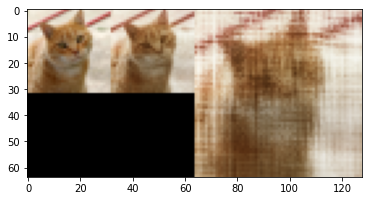

In [11]:
pred = SuperResolution(img, n_SR=n_SR, n_PE=n_PE, epochs=epochs, lr=lr)
plt.imshow(pred)
plt.imsave(os.path.join('GIFs', save_name), pred.astype('uint8'))